# Importy

In [1]:
import pandas as pd
from IPython.display import display

# Data
from Data.DataLoader import *
from Data.DataCleaner import *

# MarkowitzAnalysis
from MarkowitzAnalysis.ReturnAnalysis import *

# PortfolioAnalysis
from PortfolioAnalysis.PortfolioPerformance import *
from PortfolioAnalysis.PortfolioLoader import *

# PositionAnalysis
from PositionAnalysis.PositionManipulations import *

# Plotting
from Plotting.Plotter import *
from Plotting.EfficientFrontierPlot import *

# Backtest
from Backtest.Backtest import *

from warnings import filterwarnings
filterwarnings('ignore')

# Działanie właściwego programu

## Scenariusz 0. Aktualizacja danych do obecnej daty

#### Właściwy kod

In [ ]:
start, end = '2025-02-27', '2025-03-17'

print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")

dataloader = DataLoader()
data = dataloader.loadInstrumentsData(start, end, verbose=True)

[INFO] Rozpoczynam pracę programu: 2025-03-17 18:28:56
	Pobieramy brakujące dane od 2025-03-14 do 2025-03-17...
	Rozpoczynam pobieranie danych dla 1318 instrumentów.
	Pozostało 100%.
	[OSTRZEŻENIE] Nie udało się pobrać IU5C.DE. Zasypiamy na 10 sekund... wstajemy!


## Scenariusz 1. Analiza obecnej pozycji przez łączenie z API
Uwaga: scenariusz nieaktywny ze względu na odłączenie dostępu do API przez XTB. Kod zostanie odpowiednio dostosowany w przyszłości.

Tutaj trzeba się zastanowić, jaka ma być ścieżka logiczna w kodzie!

In [ ]:
print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")

dl = DataLoader()
info = dl.loadInstrumentsInfo()

pm = PositionManipulator(info=info,
                         filename_load='Pozycja od 10.12.2024 do 10.03.2025',
                         filepath_load='Positions')
pa = pm.AnalyzePosition()

display(pa.getSummary())

print(f"Zwrot z portfela: {pa.getPCTReturn()}%")
print(f"Zysk z inwestycji: {pa.getPLNReturn()} PLN")

[INFO] Rozpoczynam pracę programu: 2025-03-04 09:12:30
		Wysyłam zapytanie do API... 		Wysyłam zapytanie do API... 		Wysyłam zapytanie do API... 		Wysyłam zapytanie do API... 

,P500.DE,FLXI.DE,4GLD.DE,ESD.FR
CzasOtwarcia,2024-12-10 15:50:41,2024-12-10 15:51:14,2024-12-10 15:52:16,2024-12-10 15:51:46
WartoscPoczatkowaPLN,389.79,539.99,210.0,58.99
CenaOtwarcia,1134.05,43.55,82.2,24.307
CenaAktualna,1102.15,37.32,88.93,23.401
Zwrot [%],-2.812927,-14.305396,8.187348,-3.727321
KursWalutowyOtwarcia,4.281605,4.281605,4.281605,4.077424
KursWalutowyAktualny,4.138802,4.138802,4.138802,3.943384
ZwrotWalutowy [%],-3.335268,-3.335268,-3.335268,-3.28737
CenaOtwarciaPLN,4855.55415,186.463898,351.947931,99.109945
CenaAktualnaPLN,4561.580624,154.460091,368.063662,92.279129


Zwrot z portfela: -9.24%
Zysk z inwestycji: -110.73 PLN


## Scenariusz 2. Wybór nowej pozycji

In [9]:
freq = '6M'

start, end = generate_start_end(shift_date(now(), -3), freq=freq, len_train=3)

print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")
print(f"[INFO] Pracujemy na danych z okresu od {start} do {end}")

dataloader = DataLoader()
data = dataloader.loadInstrumentsData(start_date=start, 
                                      end_date=end, 
                                      filename='InstrumentsData')
info = dataloader.loadInstrumentsInfo()

returnRates = DataCleaner(data, info, verbose=False).getReturnRates(freq)

# 'pp' jest klasy PortfolioPerformance
pp = MarkowitzOptimization(returnRates, freq).getOptimalWeights(model='max_sharpe', risk_method='oas')

# Możemy zapoznać się ze statystykami zaproponowanej pozycji
print()
pp.getSummary()

[INFO] Rozpoczynam pracę programu: 2025-03-17 19:46:39
[INFO] Pracujemy na danych z okresu od 2023-09-18 do 2025-03-14
[INFO] Załadowano 825 instrumentów.

Czas przeprowadzenia analizy: 2025-03-17 19:47:05.
Opisywany obiekt: Wstępna analiza.

Zastosowane kryterium wyboru: max_sharpe.
Metoda estymacji ryzyka: oas.
Poziom ufności: 0.95.

Okres inwestycji: 6M.
Oczekiwany zwrot z portfela [%]: 4.9575
Oczekiwane ryzyko portfela [%]: 1.0384
	Przedział ufności dla stóp zwrotu [%]: [3.5573, 6.7086]
Sharpe Ratio portfela: 1.8737

Skład portfela:
	HDLV.DE:
		Waga w portfelu [%]: 1.063
		Oczekiwana stopa zwrotu [%]: 7.8848
		Oczekiwana stopa ryzyka [%]: 4.6078
		Przedział ufności dla stóp zwrotu [%]: [0.3331, 14.3748]
	ESIF.DE:
		Waga w portfelu [%]: 1.013
		Oczekiwana stopa zwrotu [%]: 12.1494
		Oczekiwana stopa ryzyka [%]: 4.8341
		Przedział ufności dla stóp zwrotu [%]: [5.4744, 20.6518]
	STZ.PA:
		Waga w portfelu [%]: 1.002
		Oczekiwana stopa zwrotu [%]: 12.1729
		Oczekiwana stopa ryzyka [%]: 

#### Scenariusz 2a. Statystyki nas zainteresowały i chcemy zapisać rekomendację na później.

In [10]:
pp.getSummary(verbose=False, save_dict=True, filename='rec3', filepath='Recommendations')

[INFO] Zmieniam 'Rodzaj' z 'Wstępna analiza' na 'Rekomendacja' i zapisuję.


#### Scenariusz 2b. Chcemy przekalkulować skład portfela na PLN z zapisanej wcześniej rekomendacji.

In [ ]:
K = 1000 # kwota do wpłacenia

pm = PositionManipulator(info = info, 
                         filename_load = 'pos1', 
                         filepath_load = 'Recommendations')
pm.Recalculate(K)

Skład portfela przeliczony dla kwoty 1000 PLN:
	ESIS.DE: 72.53 PLN
	SPYC.DE: 91.15 PLN
	GRE.PA: 346.11 PLN
	ASI.PA: 49.53 PLN
	DXSK.DE: 52.25 PLN
	S7XE.DE: 146.94 PLN
	BXX.PA: 84.51 PLN
	LYBK.DE: 86.57 PLN
	BNKE.PA: 70.42 PLN


#### Scenariusz 2c. Chcemy otwierać pozycję zapisaną w rekomendacji.
W rzeczywistości najpierw wykonujemy rekalkulację dla konkretnej kwoty (Scenariusz 2b), otwieramy pozycję w aplikacji XTB i dopiero uruchamiamy poniższy kod.

In [11]:
K = 1000 # kwota do wpłacenia
filename_load = 'rec3' # nazwa pliku z rekomendacją
position_start = ... # data dzienna otwarcia pozycji
position_end = ... # data dzienna zamknięcia pozycji (patrzymy na 'freq')

info = DataLoader().loadInstrumentsInfo()
pm = PositionManipulator(info = info, 
                         filename_load = filename_load, 
                         filepath_load = 'Recommendations')

pm.OpenPosition(K = 1000., filename_save='pos3')
# pm.OpenPosition(filename_save=f'Pozycja od {position_start} do {position_end}')

#### Scenariusz 2d. Co kryje w sobie słownik z zapisem pozycji?

In [2]:
statDict = LoadDict('pos1', 'Positions')
statDict

{'OczekiwanyZwrotPortfela': 1.9237,
 'OczekiwaneRyzykoPortfela': 0.689,
 'PrzedziałUfnościZwrotuPortfela': {'lowCI': 1.3061, 'highCI': 2.4231},
 'SharpeRatio': 2.4607,
 'SkładPortfela': {'LIRU.DE': 5.231,
  'DTLE.L': 10.505,
  'SPYC.DE': 5.259,
  'ESIS.DE': 2.861,
  'GRE.PA': 25.673,
  'BTEC.L': 5.272,
  'S7XE.DE': 26.301,
  'ICHN.AS': 2.89,
  'X7PS.L': 2.119,
  'BXX.PA': 12.221},
 'OczekiwaneZwroty': {'LIRU.DE': 1.9736,
  'DTLE.L': 0.8083,
  'SPYC.DE': 1.3566,
  'ESIS.DE': 1.1341,
  'GRE.PA': 1.2729,
  'BTEC.L': 1.117,
  'S7XE.DE': 4.4424,
  'ICHN.AS': -0.3793,
  'X7PS.L': 3.1997,
  'BXX.PA': 0.171},
 'OczekiwaneRyzyka': {'LIRU.DE': 1.6104,
  'DTLE.L': 2.0457,
  'SPYC.DE': 2.1638,
  'ESIS.DE': 2.1777,
  'GRE.PA': 2.228,
  'BTEC.L': 1.7091,
  'S7XE.DE': 2.5053,
  'ICHN.AS': 2.8397,
  'X7PS.L': 2.7432,
  'BXX.PA': 3.2584},
 'PrzedziałyUfnościZwrotów': {'LIRU.DE': {'lowCI': 0.7355, 'highCI': 3.1938},
  'DTLE.L': {'lowCI': -1.8109, 'highCI': 3.0903},
  'SPYC.DE': {'lowCI': -1.5073, 'highC

#### Scenariusz 1e. Schludne podsumowanie obecnie otwartej pozycji

In [2]:
info = DataLoader().loadInstrumentsInfo()
pm = PositionManipulator(info = info, 
                         filename_load = 'pos1', 
                         filepath_load = 'Positions')
pm.AnalyzePosition().getSummary()

,Okres zawarcia pozycji,Czas otwarcia pozycji,Obecny czas,Przewidywana data zamknięcia pozycji
,14 dni,2025-03-17 19:14:08,2025-03-17 22:50:23,2025-03-31


,Początkowy kurs walutowy (Ask),Obecny kurs walutowy (Bid),Stopa zwrotu [%]
EURPLN,4.2184,4.1625,-1.3267
USDPLN,3.8663,3.8109,-1.4325
GBPPLN,5.0323,4.9493,-1.6495
CHFPLN,4.4064,4.3266,-1.8125


,Waluta bazowa,Waga w portfelu [%],Wartość początkowa [PLN],Kurs początkowy,Kurs obecny,Stopa zwrotu [%],Kurs początkowy [PLN],Kurs obecny [PLN],"Stopa zwrotu [PLN, %]"
LIRU.DE,EUR,5.231,52.31,78.2600,78.1000,-0.2044,330.1357,325.0899,-1.5284
DTLE.L,EUR,10.505,105.05,3.0560,3.0520,-0.1309,12.8916,12.7039,-1.4558
SPYC.DE,EUR,5.259,52.59,225.9000,225.5500,-0.1549,952.9473,938.8481,-1.4795
ESIS.DE,EUR,2.861,28.61,5.6960,5.6800,-0.2809,24.0283,23.6429,-1.6038
GRE.PA,EUR,25.673,256.73,1.8540,1.8482,-0.3128,7.8210,7.6931,-1.6353
BTEC.L,EUR,5.272,52.72,6.5092,6.5062,-0.0461,27.4589,27.0822,-1.3721
S7XE.DE,EUR,26.301,263.01,141.1200,141.0000,-0.0850,595.3073,586.9101,-1.4106
ICHN.AS,USD,2.890,28.90,5.8278,5.8190,-0.1510,22.5322,22.1759,-1.5814
X7PS.L,EUR,2.119,21.19,146.2300,146.1100,-0.0821,616.8636,608.1804,-1.4076
BXX.PA,EUR,12.221,122.21,0.6315,0.6289,-0.4117,2.6639,2.6178,-1.7329


,Zwrot z portfela [%],"Zwrot z portfela [PLN, %]","Oczekiwany zwrot z portfela [PLN, %]","Przedział ufności (0.95) zwrotu portfela [PLN, %]",Zwrot nominalny [PLN]
,-0.2022,-1.5071,1.9237,"[1.3061, 2.4231]",-15.0706


## Scenariusz 3. Analiza konkretnego portfela

#### Wariant 1. Podajemy dane ręcznie

In [ ]:
print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")

portfolio = {'P500.DE': 32.56, 
             '4GLD.DE': 17.47, 
             'FLXI.DE': 45.06, 
             'ESD.FR': 4.91}

start, end = '2023-07-01', '2024-12-10'
freq = '3M'

dataloader = DataLoader()
data = dataloader.loadInstrumentsData(start, end)
info = dataloader.loadInstrumentsInfo()

datacleaner = DataCleaner(data, info, load_only=list(portfolio.keys()))
data = datacleaner.getBidPrice()
returnRates = datacleaner.getReturnRates(freq)
pp = PortfolioPerformance(portfolio, returnRates, freq, 'empirical', 'max_utility', data=data)
pp.getSummary()

[INFO] Rozpoczynam pracę programu: 2025-02-28 15:36:55
Opis wygenerowany 2025-02-28 15:36:58.
Okres inwestycji: 3M.
Zastosowane kryterium wyboru: max_utility.
Metoda estymacji ryzyka: empirical.
Poziom ufności: 0.95.
Oczekiwany zwrot z portfela [%]: 4.4147
Oczekiwane ryzyko portfela [%]: 3.5625
Przedział ufności dla stóp zwrotu [%]: [-1.5849, 9.6473]
Sharpe Ratio portfela: 0.8165
Skład portfela:
	P500.DE:
		Waga w portfelu [%]: 32.56
		Oczekiwana stopa zwrotu [%]: 4.4824
		Oczekiwana stopa ryzyka [%]: 5.2004
		Przedział ufności dla stóp zwrotu [%]: [-3.4643, 13.0589]
	4GLD.DE:
		Waga w portfelu [%]: 17.47
		Oczekiwana stopa zwrotu [%]: 5.3295
		Oczekiwana stopa ryzyka [%]: 5.9765
		Przedział ufności dla stóp zwrotu [%]: [-3.49, 15.3959]
	FLXI.DE:
		Waga w portfelu [%]: 45.06
		Oczekiwana stopa zwrotu [%]: 4.071
		Oczekiwana stopa ryzyka [%]: 4.5783
		Przedział ufności dla stóp zwrotu [%]: [-1.9526, 12.2865]
	ESD.FR:
		Waga w portfelu [%]: 4.91
		Oczekiwana stopa zwrotu [%]: 3.865
		Ocz

##### Wariant 1a. Chcemy zapisać statystyki portfela na później.

In [ ]:
SaveDict(pp.getStatDict(), 'Pozycja od 10.12.2024 do 10.03.2025', 'Positions')

#### Wariant 2. Ładujemy zapisany wcześniej portfel/pozycję/rekomendację.

In [ ]:
print(f"[INFO] Rozpoczynam pracę programu: {now(False)}\n")

start, end = '2024-01-01', '2025-03-14'
pl = PortfolioLoader('Pozycja od 2025-03-17 do 2025-03-28')
# pl = PortfolioLoader('pos1', 'Recommendations')
pl.getSummary()

[INFO] Rozpoczynam pracę programu: 2025-03-17 11:39:10

Opis wygenerowany 2025-03-17 11:37:52.
Opisywany obiekt: Otwarta pozycja.
Czas otwarcia pozycji: 2025-03-17 11:38:10.
Okres inwestycji: 2w.
Zastosowane kryterium wyboru: max_sharpe.
Metoda estymacji ryzyka: oas.
Poziom ufności: 0.95.
Oczekiwany zwrot z portfela [%]: 1.9627
Oczekiwane ryzyko portfela [%]: 0.7435
Przedział ufności dla stóp zwrotu [%]: [1.3319, 2.6846]
Sharpe Ratio portfela: 2.3329
Skład portfela:
	ESIS.DE:
		Waga w portfelu [%]: 7.253
		Oczekiwana stopa zwrotu [%]: 1.0516
		Oczekiwana stopa ryzyka [%]: 2.1401
		Przedział ufności dla stóp zwrotu [%]: [-1.8278, 3.2278]
	SPYC.DE:
		Waga w portfelu [%]: 9.115
		Oczekiwana stopa zwrotu [%]: 1.2484
		Oczekiwana stopa ryzyka [%]: 2.1315
		Przedział ufności dla stóp zwrotu [%]: [-1.5073, 3.5857]
	GRE.PA:
		Waga w portfelu [%]: 34.611
		Oczekiwana stopa zwrotu [%]: 1.4197
		Oczekiwana stopa ryzyka [%]: 2.1983
		Przedział ufności dla stóp zwrotu [%]: [-0.9839, 4.502]
	ASI.PA:

##### Wariant 2a. Poddajemy ten portfel/pozycję/rekomendację dalszej analizie

In [ ]:
dataloader = DataLoader()
data = dataloader.loadInstrumentsData(start, end)
info = dataloader.loadInstrumentsInfo()

datacleaner = DataCleaner(data, info, load_only=pl.symbols)
data = datacleaner.getBidPrice()
returnRates = datacleaner.getReturnRates(pl.freq)

pp = pl.getPortfolio(returnRates, data)
# z obiektu 'pp' można teraz odzyskać historyczny kurs portfela, stopy zwrotu, ryzyko itp.

## Scenariusz 4. Wykresy dla konkretnego portfela

[INFO] Rozpoczynam pracę programu: 2025-03-17 11:41:26

[INFO] Wygładzamy dane, obliczamy zmienność...
[INFO] Rysujemy wykresy...


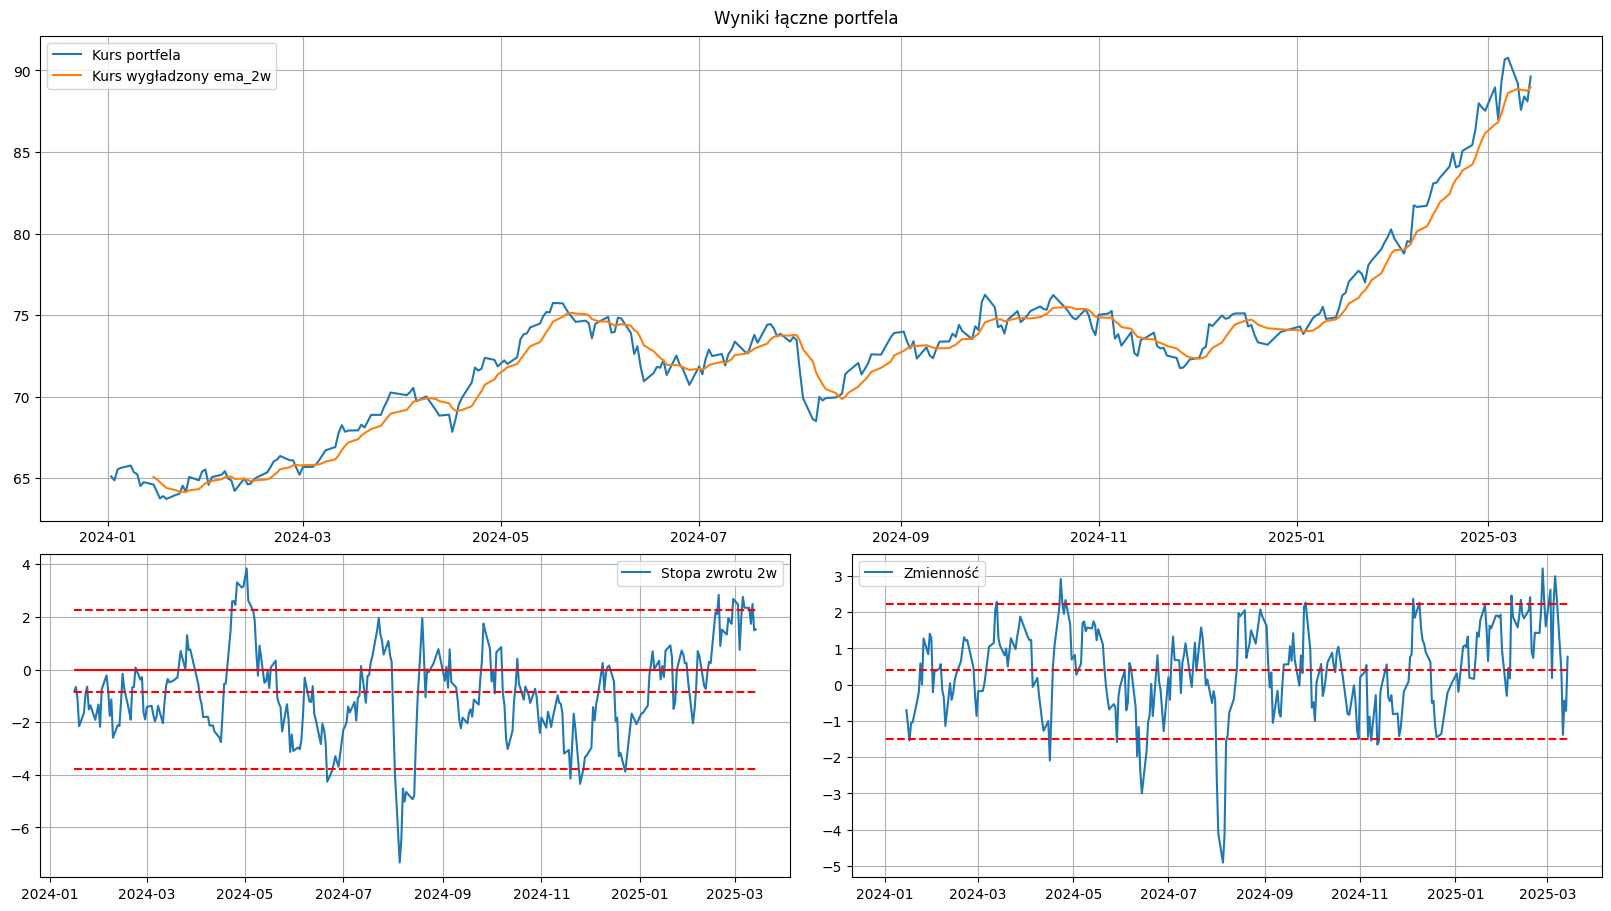

In [ ]:
print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")

pl = PortfolioLoader('Pozycja od 2025-03-17 do 2025-03-28', 'Positions')
freq = pl.freq # można to pobrać z obiektu 'pl' jako 'pl.freq', ale można też ustawić na inną wartość

# print()
# pl.getSummary()

print()
start, end = '2024-01-01', '2025-03-14'
dataloader = DataLoader()
data = dataloader.loadInstrumentsData(start, end)
info = dataloader.loadInstrumentsInfo()

datacleaner = DataCleaner(data, info, load_only=pl.symbols)
data = datacleaner.getBidPrice()
returnRates = datacleaner.getReturnRates(freq)

plotter = Plotter(pl.portfolio,
                  data,
                  returnRates,
                  freq,
                  pl.model,
                  pl.risk_method,
                  compare='ema_2w')
plotter.plot(show_instruments=False)

## Scenariusz 5. Wykres "Efficient Frontier"

In [ ]:
start, end = '2024-01-01', '2025-02-03'

print(f"[INFO] Rozpoczynam pracę programu: {now(False)}")

dataloader = DataLoader()
data = dataloader.loadInstrumentsData(start, end)
info = dataloader.loadInstrumentsInfo()

datacleaner = DataCleaner(data, info)

[INFO] Rozpoczynam pracę programu: 2025-02-04 18:02:51
[INFO] Usuwanie instrumentów o wysokich kosztach obsługi.
	Aktualizacja danych...
	Pozostawiam 953 instrumentów.
[INFO] Usuwanie instrumentów o wysokich spreadach.
	Aktualizacja danych...
	Pozostawiam 953 instrumentów.
[INFO] Usuwanie instrumentów o dużych brakach w danych.
	Aktualizacja danych...
	Pozostawiam 908 instrumentów.
[INFO] Usuwanie instrumentów na podstawie ich zmienności.
	Aktualizacja danych...
	Pozostawiam 839 instrumentów.


In [ ]:
freq = '3M'
returnRates = datacleaner.getReturnRates(freq)
ef = EfficientFrontierPlot(returnRates, freq, Npoints=80)

[INFO] Przygotowuję dane do wykresu...
	Pozostało 100.0%
	Pozostało 87.5%
	Pozostało 75.0%
	Pozostało 62.5%
	Pozostało 50.0%
	Pozostało 37.5%
	Pozostało 25.0%
	Pozostało 12.5%
[INFO] Wyznaczamy portfel 'max_sharpe'...
[INFO] Wyznaczamy portfele 'max_utility'...


[INFO] Generuję 5000 portfeli losowych...
	Pozostało 100.0%
	Pozostało 90.0%
	Pozostało 80.0%
	Pozostało 70.0%
	Pozostało 60.0%
	Pozostało 50.0%
	Pozostało 40.0%
	Pozostało 30.0%
	Pozostało 20.0%
	Pozostało 10.0%
[INFO] Rysuję wykres...


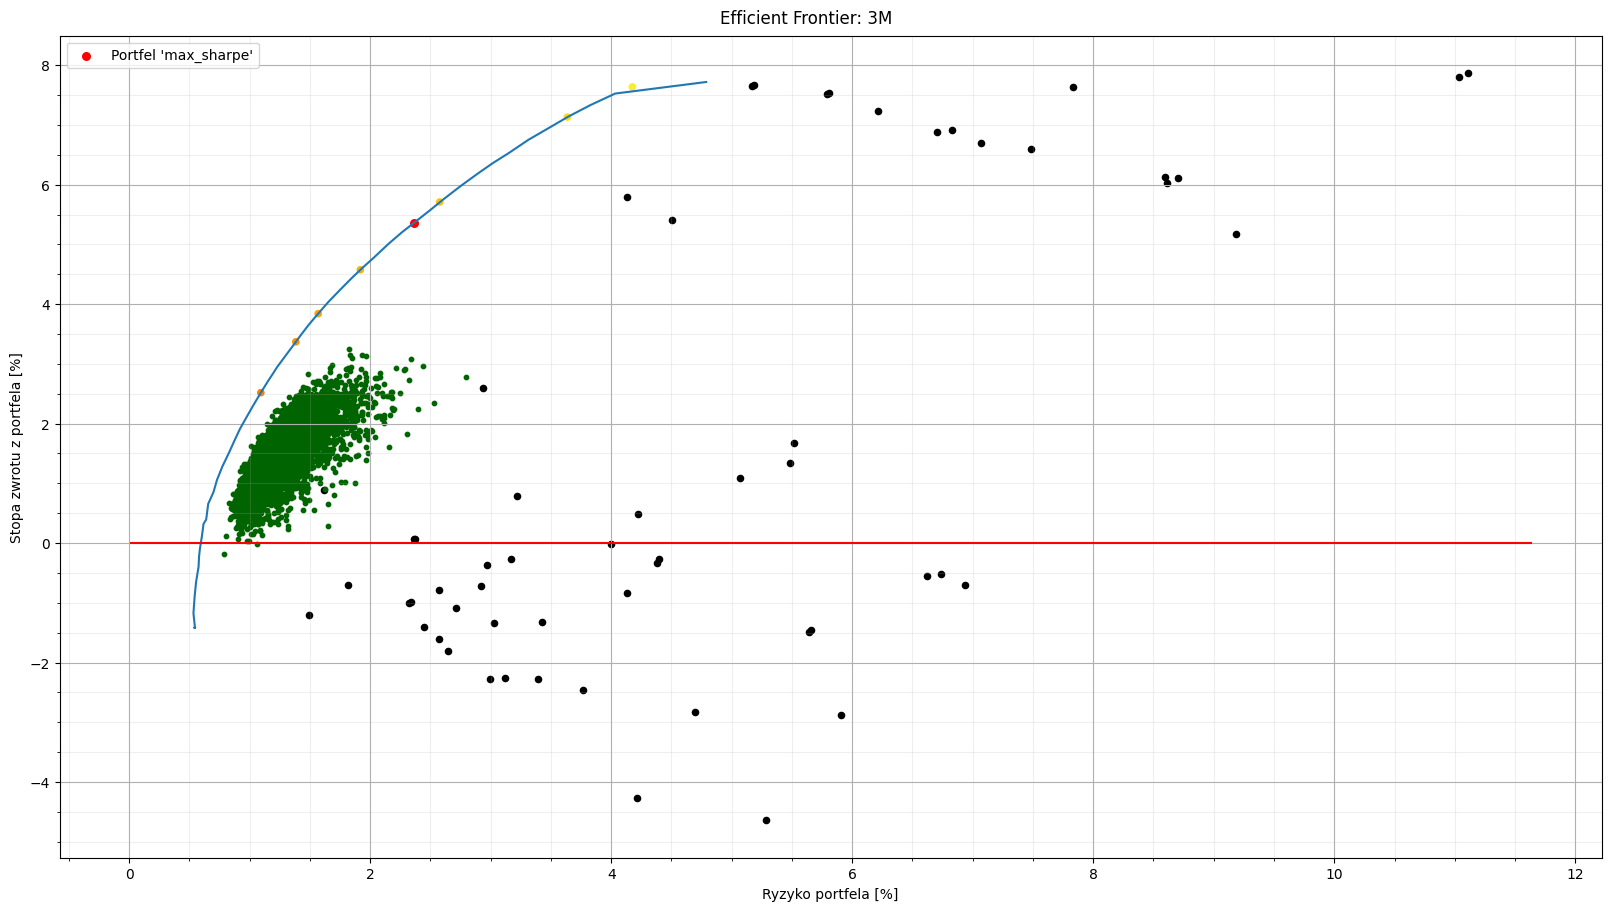

In [ ]:
ef.plot(Nrandom=5000)

## Scenariusz 6: Backtest modelu

In [ ]:
start, end = '2016-07-01', '2025-03-01'

freqs = ['1w', '2w', '3w', '1M', '6w', '2M', '3M', '4M', '5M', '6M', '8M', '1Y']
len_trains = [1, 2, 3, 4, 5, 6, 7]

beginning_time = time.time()
for i, freq in enumerate(freqs):
    
    if i > 0:
        estimate_time_to_end(i, len(freqs), beginning_time)
            
    for len_train in len_trains:
        
        print(f"[INFO] Backtest z freq = {freq}, len_train = {len_train}")
        
        bt = Backtest(start, end, freq, len_train)
        bt.runTrainTest()

        BacktestSummary = bt.summary
        SaveData(BacktestSummary, f'Backtest freq {freq} len_train {len_train}', 'Backtest')
        print()

[INFO] Backtest z freq = 1M, len_train = 1
[INFO] Okres 1 z 101. Pobieramy dane od 2016-07-31 do 2016-10-31: 2025-03-02 23:47:16
	[INFO] Trening w okresie od 2016-07-31 do 2016-09-30
	Oczekiwany zwrot treningowy: 4.28%
	Sharpe Ratio: 1.37

	[INFO] Test w okresie od 2016-09-30 do 2016-10-31
	Rzeczywisty zwrot w okresie testowym: 1.50%
	Treningowy przedział ufności: [1.06%, 7.97%]

[INFO] Okres 2 z 101. Pobieramy dane od 2016-08-31 do 2016-11-30: 2025-03-02 23:47:22
	[INFO] Trening w okresie od 2016-08-31 do 2016-10-31
	Oczekiwany zwrot treningowy: 3.23%
	Sharpe Ratio: 1.95

	[INFO] Test w okresie od 2016-10-31 do 2016-11-30
	Rzeczywisty zwrot w okresie testowym: 0.85%
	Treningowy przedział ufności: [0.88%, 4.75%]

[INFO] Okres 3 z 101. Pobieramy dane od 2016-09-30 do 2016-12-31: 2025-03-02 23:47:28
	[INFO] Trening w okresie od 2016-09-30 do 2016-11-30
	Oczekiwany zwrot treningowy: 3.82%
	Sharpe Ratio: 2.45

	[INFO] Test w okresie od 2016-11-30 do 2016-12-31
	Rzeczywisty zwrot w okresie 

KeyError: 'TrueReturn'

### Zapis backtestu do jednego pliku

In [ ]:
import os
files = [x for x in os.listdir('Backtest') if x.find('freq') != -1]

full_data = pd.DataFrame()

for file in files:
    
    file_split = file.split(' ')
    freq = file_split[2]
    len_train = file_split[-1][0]

    data = pd.read_csv('Backtest/'+file, index_col='Unnamed: 0')
    data['Freq'] = freq
    data['LenTrain'] = len_train
    data['StartTest'] = data.index
    data.index = range(data.shape[0])
    
    full_data = pd.concat([full_data, data])

full_data.index = range(full_data.shape[0])
full_data = full_data.dropna()
SaveData(full_data, 'Full backtest', 'Backtest')

### Ładowanie pliku z zapisem backtestu

In [ ]:
data = pd.read_csv('Backtest/Full backtest.csv', index_col='Unnamed: 0').drop(index=[787])
data.head()

,ExpectedReturn,ConfIntLow,ConfIntHigh,SharpeRatio,TrueReturn,Error,InConfInt,Freq,LenTrain,StartTest
0,4.28,1.06,7.97,1.367520,1.50,-2.78,True,1M,1,2016-09-30
1,3.23,0.88,4.75,1.951575,0.85,-2.38,False,1M,1,2016-10-31
2,3.82,1.85,5.32,2.449936,4.60,0.78,True,1M,1,2016-11-30
3,6.51,5.49,7.58,6.317600,4.61,-1.90,False,1M,1,2016-12-31
4,0.91,-0.20,2.08,0.401199,-0.61,-1.52,False,1M,1,2017-01-31


In [ ]:
data['SharpeClass'] = data['SharpeRatio'].apply(lambda x: int(x))

### Analiza wyników backtestu

In [ ]:
pd.crosstab(data['InConfInt'], data['LenTrain'], normalize='columns')

LenTrain,1,2,3,4,5,6,7
InConfInt,,,,,,,
False,0.306583,0.238404,0.212828,0.187564,0.221267,0.183371,0.187275
True,0.693417,0.761596,0.787172,0.812436,0.778733,0.816629,0.812725


<AxesSubplot: title={'center': 'TrueReturn'}, xlabel='[LenTrain]'>

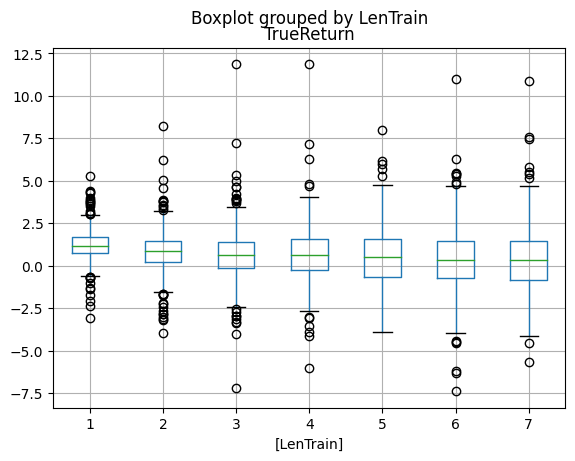

In [ ]:
data.query("Freq == '1w'")[['TrueReturn', 'LenTrain']].boxplot(by='LenTrain', grid=True)

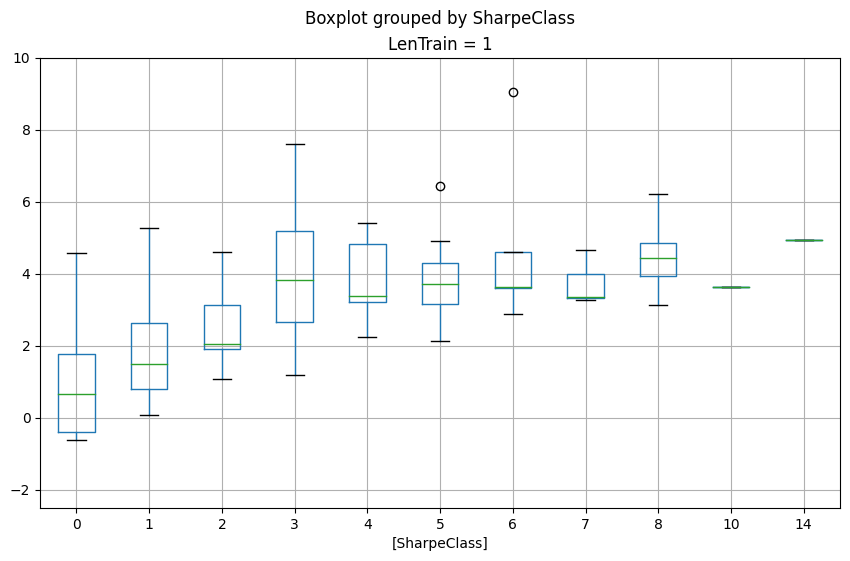

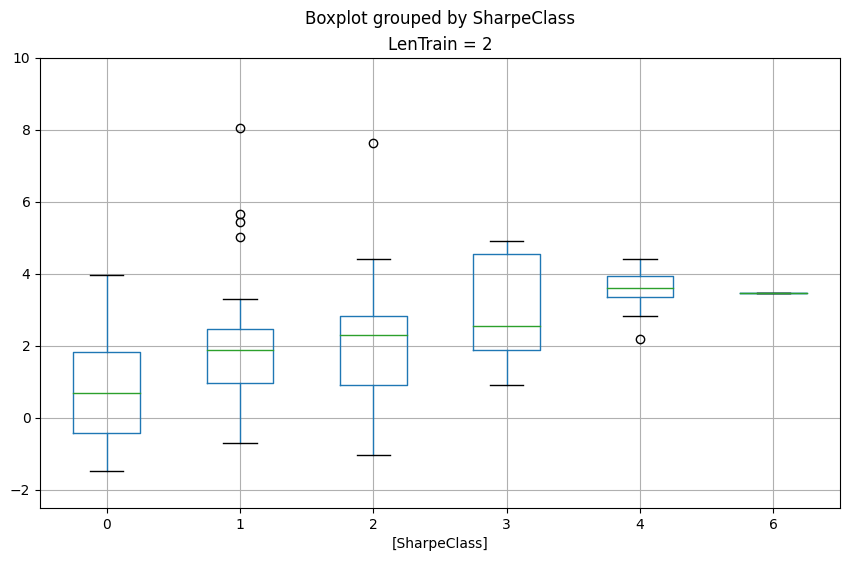

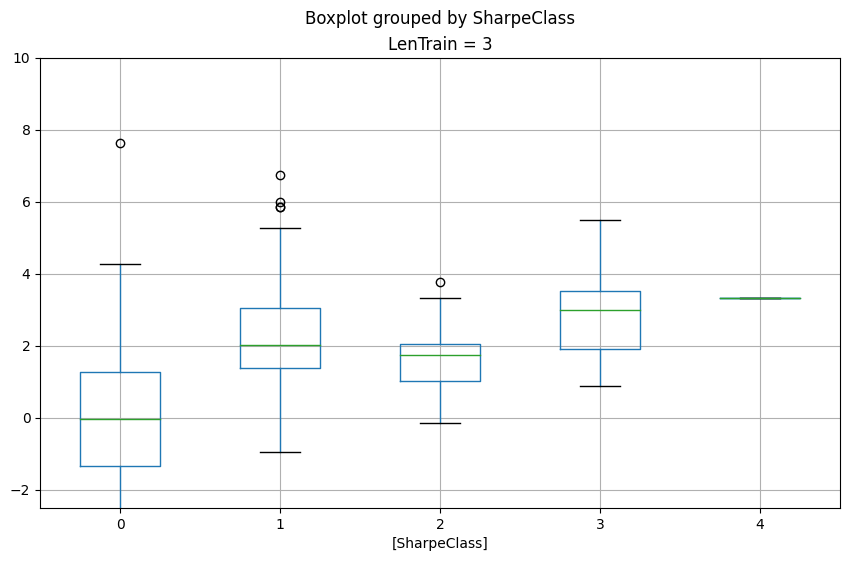

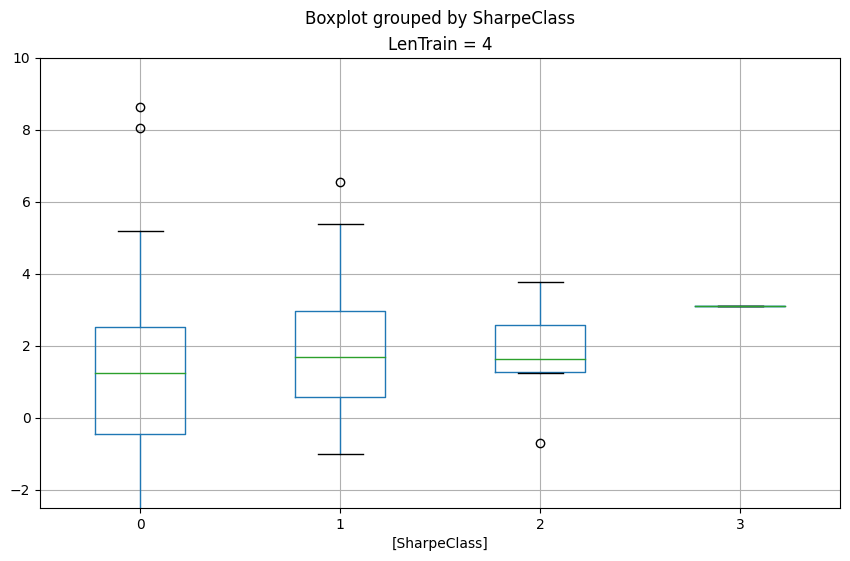

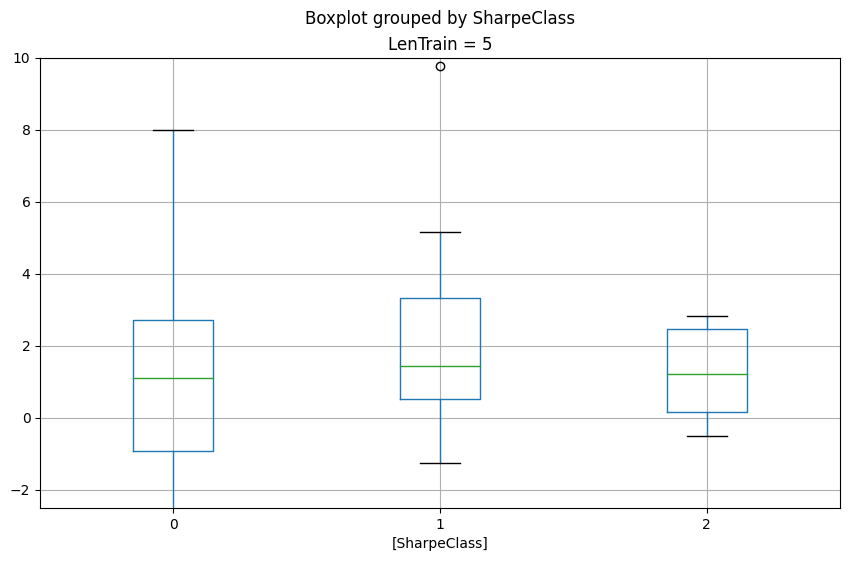

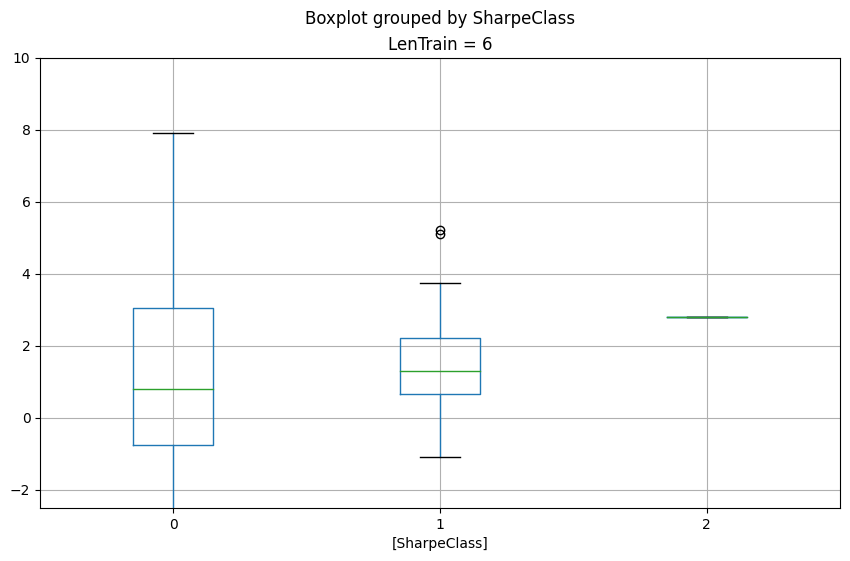

In [ ]:
for i in range(1, 7):
    df = data.query(f"Freq == '1M' and LenTrain == {i}")[['TrueReturn', 'SharpeClass']]
    ax = df.boxplot(by='SharpeClass', figsize=(10, 6), grid=True)
    ax.set_title(f"LenTrain = {i}")
    ax.set_ylim(-2.5, 10)

# Brudnopis

Trzeba teraz zintegrować dane z symbolami:
- skleić Info i TER w jeden słownik
- potem ujednolicić nazwy instrumentów w danych i słowniku względem poprawnych nazw z *yfinance*

Zrobione!